# occupancy prediction - forecasting using LSTM

> Author: Trevor Bergstrom <br>
> Date: 2022-08-27 <br>
> Kernel: Python 3.10 <br>

## init

In [57]:
import os 
os.chdir('/Users/trevor/Work/1-projects/occupancy-prediction')

import datetime as dt
import numpy as np
import pandas as pd 
import pathlib 
import typing as ty

# plotting
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()
import altair as alt
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [2]:
DATASTORE = pathlib.Path('datastore')
assert DATASTORE.exists(), f'unable to find datastore at: {DATASTORE}'

# data processing

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## load

In [4]:
data_path = DATASTORE.joinpath('occ-counts.csv')

df = (
    pd.read_csv(data_path, parse_dates=['timestamp']).rename(columns={'count': 'occ'})
    .query('location == "POP"')
    .query('5 < timestamp.dt.hour < 24')
    .drop(columns=['location', 'capacity', 'subLabel', 'lastUpdate'])
    .reindex(columns=['timestamp', 'occ'])
)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7160 entries, 0 to 22647
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  7160 non-null   datetime64[ns]
 1   occ        7160 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 167.8 KB


None

,timestamp,occ
0,2022-03-28 16:02:42.738457,177
3,2022-03-28 16:04:30.367773,184
6,2022-03-28 16:04:53.611084,191
9,2022-03-28 16:11:59.003963,207
12,2022-03-28 16:22:04.569012,227


## feature processing

In [5]:
FEATURES = ['occ', 'day', 'hour']
NUM_FEATURES = len(FEATURES)

occs = (
    df
    # resample hourly
    .groupby(pd.Grouper(key='timestamp', freq='1H')).occ.mean()
    .fillna(0).reset_index()
    .query('5 < timestamp.dt.hour < 24')
    # skip past section of missing data
    .loc[lambda d: d.timestamp >= pd.to_datetime('2022-05-01')]
    # add day of week
    .assign(
        day = lambda d: d.timestamp.dt.strftime('%w').astype('int'),
        hour = lambda d: d.timestamp.dt.hour.astype('int'),
    )
)

occs.head()

,timestamp,occ,day,hour
806,2022-05-01 06:00:00,0.000000,0,6
807,2022-05-01 07:00:00,16.000000,0,7
808,2022-05-01 08:00:00,53.333333,0,8
809,2022-05-01 09:00:00,113.500000,0,9
810,2022-05-01 10:00:00,218.666667,0,10


## sequence creation

In [29]:
SEQUENCE_SIZE = 24 * 7
PREDICTION_SIZE = 1

def create_sequences(data: pd.DataFrame, seq_size: int, pred_size: int) -> ty.Tuple[np.ndarray, np.ndarray]:
    """ creates sequences from input dataframe """
    seqs, targets = [], []
    for chunk in data.rolling(seq_size + pred_size):
        if len(chunk) < seq_size + pred_size:
            continue
        seqs.append(chunk[:seq_size].values)
        targets.append(chunk[-pred_size:].values)
        
    return np.stack(seqs), np.stack(targets)[:, :, FEATURES.index('occ')].reshape(-1)


all_seqs_, all_targets_ = create_sequences(occs.set_index('timestamp')[FEATURES], SEQUENCE_SIZE, PREDICTION_SIZE)
all_seqs_.shape, all_targets_.shape

((1963, 168, 3), (1963,))

## scaling

In [28]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(np.array([[0, 0, 6], [800, 6, 23]]))
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler.fit(np.array([[0], [800]]))

MinMaxScaler()

In [31]:
all_seqs = scaler.transform(all_seqs_.reshape(-1, NUM_FEATURES)).reshape(-1, SEQUENCE_SIZE, NUM_FEATURES)
all_targets = target_scaler.transform(all_targets_.reshape(-1, 1)).reshape(-1)
all_seqs.shape, all_targets.shape

((1963, 168, 3), (1963,))

## train / test split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(all_seqs, all_targets, test_size=0.3)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1374, 168, 3), (1374,), (589, 168, 3), (589,))

# LSTM

In [33]:
import tensorflow as tf
print(f'tesnforflow version: {tf.__version__}')

tesnforflow version: 2.9.1


## model definition

In [36]:
LSTM_ACTIVATION = 'tanh'

layers = [
    tf.keras.Input(shape=(SEQUENCE_SIZE, NUM_FEATURES)),
    tf.keras.layers.LSTM(units=64, activation=LSTM_ACTIVATION, return_sequences=True),
    tf.keras.layers.LSTM(units=64, activation=LSTM_ACTIVATION, return_sequences=True),
    tf.keras.layers.LSTM(units=64, activation=LSTM_ACTIVATION, return_sequences=False),
    tf.keras.layers.Dense(units=PREDICTION_SIZE, activation='linear'),
]

model = tf.keras.Sequential(layers)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 168, 64)           17408     
                                                                 
 lstm_10 (LSTM)              (None, 168, 64)           33024     
                                                                 
 lstm_11 (LSTM)              (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 83,521
Trainable params: 83,521
Non-trainable params: 0
_________________________________________________________________


## train

Epoch 1/50
121/121 [==============================] - 19s 123ms/step - loss: 0.0194 - val_loss: 0.0162
Epoch 2/50
121/121 [==============================] - 14s 113ms/step - loss: 0.0166 - val_loss: 0.0146
Epoch 3/50
121/121 [==============================] - 14s 116ms/step - loss: 0.0159 - val_loss: 0.0142
Epoch 4/50
121/121 [==============================] - 13s 111ms/step - loss: 0.0159 - val_loss: 0.0153
Epoch 5/50
121/121 [==============================] - 13s 110ms/step - loss: 0.0156 - val_loss: 0.0145
Epoch 6/50
121/121 [==============================] - 13s 110ms/step - loss: 0.0153 - val_loss: 0.0127
Epoch 7/50
121/121 [==============================] - 13s 111ms/step - loss: 0.0150 - val_loss: 0.0133
Epoch 8/50
121/121 [==============================] - 14s 112ms/step - loss: 0.0144 - val_loss: 0.0122
Epoch 9/50
121/121 [==============================] - 13s 111ms/step - loss: 0.0138 - val_loss: 0.0119
Epoch 10/50
121/121 [==============================] - 13s 112ms/step - l

<AxesSubplot:title={'center':'model training loss'}>

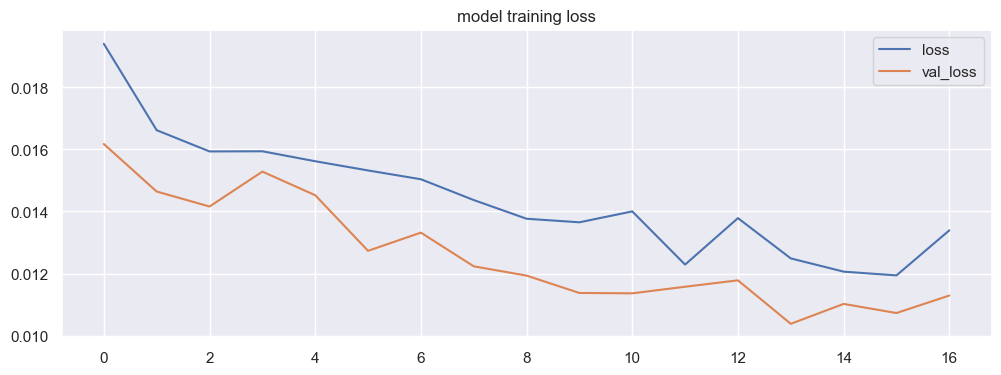

In [37]:
NUM_EPOCHS = 50
BATCH_SIZE = 8

history = model.fit(
    X_train, y_train, validation_split=0.3, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    ]
)

histdf = pd.DataFrame(history.history)
histdf.plot(figsize=(12, 4), title='model training loss')

## predict

<AxesSubplot:xlabel='loss', ylabel='Probability'>

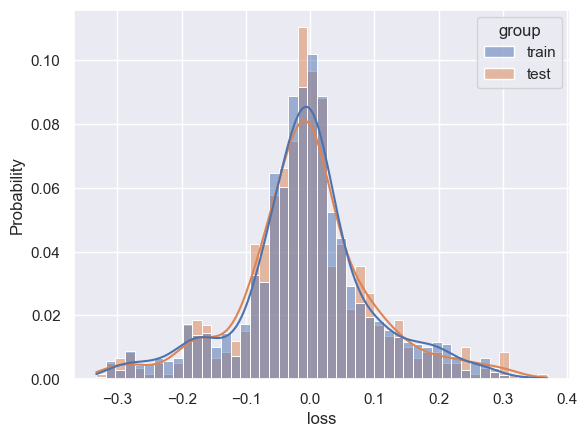

In [38]:
train_preds, test_preds = model.predict(X_train, verbose=0).reshape(-1), model.predict(X_test, verbose=0).reshape(-1)
train_loss, test_loss = y_train - train_preds, y_test - test_preds

losses = (
    pd.concat([
        pd.DataFrame(train_loss, columns=['loss']).assign(group='train'),
        pd.DataFrame(test_loss, columns=['loss']).assign(group='test'),
    ])
    .reset_index(drop=True)
)
sns.histplot(
    data=losses, x='loss', hue='group',
    stat='probability', common_norm=False, kde=True
)

# evaluation

## forecast

Horribly inefficient but super simple.

In [56]:
preds = []

for chunk in occs.rolling(SEQUENCE_SIZE + PREDICTION_SIZE):
    if len(chunk) < SEQUENCE_SIZE + PREDICTION_SIZE:
        continue
    pred = model.predict(chunk[FEATURES].iloc[:SEQUENCE_SIZE].values.reshape(1, SEQUENCE_SIZE, NUM_FEATURES), verbose=0)
    preds.append(
        chunk.iloc[-1:].assign(pred = target_scaler.inverse_transform(pred).ravel()[0])
    )

pred_df = pd.concat(preds).reset_index(drop=True)
pred_df.head()

,timestamp,occ,day,hour,pred
0,2022-05-10 12:00:00,135.500000,2,12,362.037415
1,2022-05-10 13:00:00,129.000000,2,13,363.482513
2,2022-05-10 14:00:00,88.500000,2,14,363.012756
3,2022-05-10 15:00:00,116.666667,2,15,367.504517
4,2022-05-10 16:00:00,219.333333,2,16,366.094116


<AxesSubplot:xlabel='timestamp'>

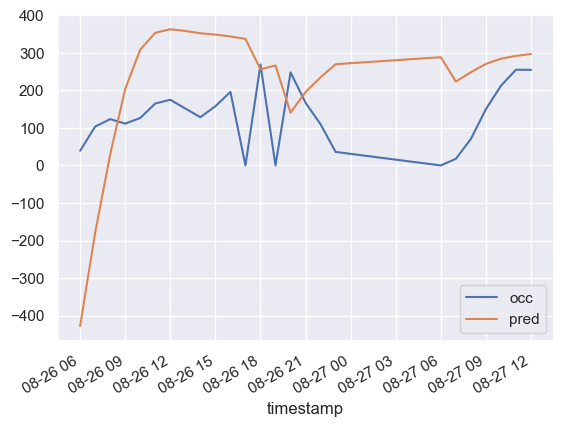

In [60]:
(
    pred_df
    .set_index('timestamp').loc[(dt.date.today() - dt.timedelta(days=1)):]
    [['occ', 'pred']].plot()
)